<a href="https://colab.research.google.com/github/Harley7Damian/PhawAI_2025/blob/NLP/NLP_TF_Model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prototipo de LSTM con oversampling**

In [1]:
# ============================
# @title Montar Google Drive
# ============================
from google.colab import drive
drive.mount('/content/drive')

# Justificación:
# Montamos Google Drive para:
#   - Acceder a los datasets que tengamos guardados en nuestra unidad.
#   - Guardar resultados intermedios (pesos, métricas, logs) de forma persistente,
#     ya que el entorno de Colab se reinicia y los datos locales se pierden.

# ============================
# 2. Clonar repositorio oficial
# ============================
%cd /content/drive/MyDrive/

!git clone https://github.com/fmplaza/EmoEvent.git
%cd EmoEvent

# Justificación:
# Clonamos el repositorio EmoEvent directamente desde GitHub porque:
#   - Contiene los scripts base y la estructura definida para trabajar con los datos.
#   - Nos aseguramos de usar exactamente la misma configuración y splits
#     que los autores del benchmark.
#   - Esto evita inconsistencias entre entornos.

Mounted at /content/drive
/content/drive/MyDrive
fatal: destination path 'EmoEvent' already exists and is not an empty directory.
/content/drive/MyDrive/EmoEvent


In [9]:
# ============================
# @title Preparar rutas de trabajo
# ============================
import os
import pandas as pd

# Rutas de los splits en español
train_path = "/content/drive/MyDrive/EmoEvent/splits/es/train.tsv"
dev_path   = "/content/drive/MyDrive/EmoEvent/splits/es/dev.tsv"
test_path  = "/content/drive/MyDrive/EmoEvent/splits/es/test.tsv"

In [10]:
# ============================================
# @title Instalar dependencias
# ============================================
!pip install tensorflow scikit-learn imbalanced-learn emoji

In [11]:
# ============================================
# @title Cargar y explorar los datos
# ============================================
from collections import Counter

train_df = pd.read_csv(train_path, sep="\t")
dev_df   = pd.read_csv(dev_path, sep="\t")
test_df  = pd.read_csv(test_path, sep="\t")

print("Ejemplo de train:")
display(train_df.head())

print("\nTamaños:")
print("Train:", train_df.shape)
print("Dev  :", dev_df.shape)
print("Test :", test_df.shape)

print("\nDistribución Train:", Counter(train_df["emotion"]))

Ejemplo de train:


,id,event,tweet,offensive,emotion
0,a0c1a858-a9b8-4cb1-8a81-1602736ff5b8,GameOfThrones,La Gran Guerra de #JuegoDeTronos nos ha dejado...,NO,others
1,9b272817-a231-4f68-bdf4-3350d4919330,Venezuela,El golpe de Estado en #Venezuela está más lejo...,NO,others
2,4bd5b1e5-4b74-440a-82f4-c2567a241011,NotreDame,No tengo una foto en la catedral de #NotreDame...,NO,sadness
3,0bb9d7c9-d781-4684-890e-a94bfb50acc0,NotreDame,#NotreDame nunca llegue a visitar tan grandios...,NO,sadness
4,88749098-d539-4500-9209-0bbfae2b109c,GameOfThrones,A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos,OFF,sadness



Tamaños:
Train: (5723, 5)
Dev  : (844, 5)
Test : (1656, 5)

Distribución Train: Counter({'others': 2800, 'joy': 1227, 'sadness': 693, 'anger': 589, 'surprise': 238, 'disgust': 111, 'fear': 65})


In [55]:
# ============================================
# @title Preprocesamiento avanzado de tweets
# ============================================
import re
import emoji

def advanced_clean(text):
    # Ensure the input is a string
    text = str(text)
    text = emoji.demojize(text)                       # Emojis → texto (demojize)
    text = re.sub(r"http\S+|www\S+", "<url>", text)   # URLs → <url>
    text = re.sub(r"@\w+", "<user>", text)            # menciones → <user>

    # Hashtags → separar palabras (captura mayúsculas, minúsculas y números)
    hashtags = re.findall(r"#\w+", text)
    for tag in hashtags:
        # separar por mayúsculas, minúsculas y números
        split_tag = ' '.join(re.findall(r'[A-Z]?[a-z]+|\d+', tag[1:]))
        text = text.replace(tag, split_tag)

    # Mantener letras, números, espacios, emojis y signos de énfasis
    # Incluye: ! ? . , : ; - _ < > y los tags <url> y <user>
    text = re.sub(r"[^a-zA-Z0-9\s!?\.,:;_\-<>]", "", text)

    # Normalizar espacios múltiples
    text = re.sub(r'\s+', ' ', text)

    return text.lower().strip()

# Aplicar preprocesamiento
train_df['tweet'] = train_df['tweet'].apply(advanced_clean)
dev_df['tweet']   = dev_df['tweet'].apply(advanced_clean)
test_df['tweet']  = test_df['tweet'].apply(advanced_clean)

### 1️⃣ **Emojis**
Los emojis son muy informativos en tweets porque comunican emociones de manera directa.

Ejemplo:

>😨 → miedo,
>😂 → alegría,
>😡 → ira

*Eliminar emojis como en el preprocesamiento anterior puede hacer perder contexto emocional.*

> **Propuesta:**
Convertir emojis en tokens de texto usando librerías como emoji o demojize.

### 2️⃣ Hashtags
* Los hashtags (#GameOfThrones) aportan información temática, no solo emocional.
* Algunos hashtags contienen palabras relevantes (#Tristeza, #Feliz) que directamente apuntan a la emoción.

> **Propuesta:**
Mantener hashtags, pero separar palabras compuestas si es posible.


### 3️⃣ Menciones (@user)
* Menos importantes para emoción; generalmente ruido.
* Mantenerlas rara vez aporta valor.
> **Propuesta:**
Eliminarlas o reemplazarlas por un token <\user>.

### 4️⃣ URLs
Generalmente no aportan información emocional directa.
> **Propuesta:** reemplazarlas por <url> o eliminarlas.

### 5️⃣ Signos de puntuación

Algunos signos pueden intensificar emoción, p. ej. !!! o ?.

> **Propuesta:**
* Mantener signos de exclamación y pregunta como tokens separados.
* Eliminar otros símbolos que no aporten valor.

## **Conclusiones**
> Emojis y hashtags son señales emocionales fuertes y conviene preservarlas como tokens, no eliminarlas.
>Menciones y URLs pueden generalizarse con tokens especiales.
>Mantener signos de énfasis (!, ?) ayuda a captar intensidad.

Con este preprocesamiento, el modelo aprenderá mejor la relación entre contenido textual, emoción y contexto.

In [56]:
# ============================================
#  @title Tokenización y secuencias
# ============================================
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 50
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['tweet'])

X_train = tokenizer.texts_to_sequences(train_df['tweet'])
X_dev   = tokenizer.texts_to_sequences(dev_df['tweet'])
X_test  = tokenizer.texts_to_sequences(test_df['tweet'])

X_train = pad_sequences(X_train, maxlen=MAX_LEN, padding='post')
X_dev   = pad_sequences(X_dev, maxlen=MAX_LEN, padding='post')
X_test  = pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

___________________

## **Análisis de técnicas según este caso**

1. **Undersampling de clases mayoritarias**
    * Reducir others y joy para igualarlas a la clase minoritaria.
    * Contras: perderías demasiados datos valiosos (por ejemplo, de others pasarías de 2800 a 65).
    * Conclusión: no recomendable, datos perdidos son demasiado importantes para NLP.

2. **Oversampling de clases minoritarias**
    *  Duplicar ejemplos de fear, disgust y surprise.
    * Riesgo: overfitting si duplicas demasiado, porque el modelo verá repetidamente los mismos tweets.
    * Conclusión: útil si se combina con class weighting y no se exagera.

3. **SMOTE o técnicas sintéticas sobre embeddings**
    * Generar vectores de tweets minoritarios (usando Word2Vec o BERT) y luego entrenar.
    * Pros: evita repetir exactamente el mismo texto.
    * Contras: requiere pipeline de embeddings; si se hace directamente sobre texto, no es factible.
    * Conclusión: buena opción avanzada si quieres balancear fuerte, especialmente para fear y disgust.

4. **Class weighting (ponderar la pérdida por clase)**
    *  Ajusta la función de pérdida para que errores en clases minoritarias tengan más peso.
    * Pros: no se altera el dataset; evita inventar datos; fácil de implementar en LSTM o Transformer.
    * Contras: no aumenta la cantidad de ejemplos, pero ayuda al modelo a prestar atención a las minoritarias.
    * Conclusión: muy recomendable, especialmente con clases tan desbalanceadas.


### **PROPUESTA A IMPLEMENTAR**
> Class weighting → obligatorio para que el modelo preste atención a clases como fear y disgust.

> Oversampling ligero de clases minoritarias (fear, disgust, surprise) → solo para dar un poco más de ejemplos al modelo, evitando duplicar demasiado.

> Evitar undersampling de las clases mayoritarias.

Este enfoque mantiene la mayoría de los datos originales, evita inventar texto y permite que las clases minoritarias sean reconocidas por el modelo.

In [57]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [58]:
# ============================================
#  @title Etiquetas y class weighting
# ============================================
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

le = LabelEncoder()
y_train = le.fit_transform(train_df['emotion'])
y_dev   = le.transform(dev_df['emotion'])
y_test  = le.transform(test_df['emotion'])

# One-hot
y_train_oh = tf.keras.utils.to_categorical(y_train)
y_dev_oh   = tf.keras.utils.to_categorical(y_dev)
y_test_oh  = tf.keras.utils.to_categorical(y_test)

# Class weighting
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
weight_dict = dict(zip(classes, class_weights))
print("Class weights:", weight_dict)


Class weights: {np.int64(0): np.float64(1.388066941547417), np.int64(1): np.float64(7.365508365508365), np.int64(2): np.float64(12.578021978021978), np.int64(3): np.float64(0.6663173826988008), np.int64(4): np.float64(0.2919897959183673), np.int64(5): np.float64(1.1797567511853226), np.int64(6): np.float64(3.435174069627851)}


Análisis de los Class Weights

Durante el preprocesamiento del dataset y la preparación del entrenamiento, se calcularon los pesos de clase (class_weight) para corregir el fuerte desbalance presente en las emociones de los tweets. Los valores obtenidos son los siguientes:

Clase (LabelEncoder)	Peso
0	1.39
1	7.37
2	12.58
3	0.67
4	0.29
5	1.18
6	3.44

Interpretación y relevancia:

1. Clases minoritarias reciben mayor peso
>- Clases con pocas muestras, como la clase 2 (12.58) y clase 1 (7.37), tienen pesos altos.
>- Esto significa que durante el entrenamiento, los errores en estas clases minoritarias serán penalizados más fuertemente, obligando al modelo a prestarles atención.
>-  Evita que el modelo prediga siempre las clases mayoritarias por conveniencia estadística.

2. Clases mayoritarias reciben menor peso
>- Clases con muchas muestras, como la clase 4 (0.29) y clase 3 (0.67), tienen pesos bajos.
>- Esto previene que el modelo se sesgue hacia las clases dominantes (others y joy) y promueve un aprendizaje más equilibrado.

3. Proporcionalidad de los pesos
>- Los pesos están calculados de forma inversa a la frecuencia de cada clase (balanced), lo que refleja la relación de desbalance real del dataset.
>- Este enfoque es adecuado para datasets de NLP desbalanceados, ya que no altera los datos originales pero ajusta la función de pérdida para priorizar correctamente todas las clases.

4. Consideraciones prácticas

Pesos demasiado altos pueden generar overfitting en clases minoritarias; por ello, en nuestro pipeline se combina este ajuste con oversampling ligero, asegurando estabilidad en el entrenamiento y mejora en métricas macro como F1-score.

Conclusión:
El uso de estos pesos permite que el modelo LSTM aprenda patrones relevantes de todas las clases de emoción, equilibrando el impacto de clases muy desbalanceadas sin perder información de las mayoritarias, lo que es crucial para tareas de clasificación emocional en tweets.

In [59]:
from collections import Counter

# Muestra el mapeo de LabelEncoder
for i, c in enumerate(le.classes_):
    print(f"{i}: {c}")

# Revisa la distribución de clases
print(Counter(y_train))


0: anger
1: disgust
2: fear
3: joy
4: others
5: sadness
6: surprise
Counter({np.int64(4): 2800, np.int64(3): 1227, np.int64(5): 693, np.int64(0): 589, np.int64(6): 238, np.int64(1): 111, np.int64(2): 65})


In [60]:
# ========================================================
#  @title Oversampling ligero de clases minoritarias
# ========================================================
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Ajusta los números según cuántos ejemplos quieras para cada clase minoritaria
ros = RandomOverSampler(sampling_strategy={
    0: 800,   # anger, antes 589
    1: 200,   # disgust, antes 111
    2: 150,   # fear, antes 65
    5: 800,   # sadness, antes 693
    6: 500    # surprise, antes 238
}, random_state=42)

X_res, y_res = ros.fit_resample(X_train, y_train)
y_res_oh = tf.keras.utils.to_categorical(y_res)
print("Distribución tras oversampling:", Counter(y_res))

Distribución tras oversampling: Counter({np.int64(4): 2800, np.int64(3): 1227, np.int64(5): 800, np.int64(0): 800, np.int64(6): 500, np.int64(1): 200, np.int64(2): 150})


Esto es oversampling ligero, suficiente para que el modelo aprenda mejor sin generar overfitting excesivo.
> *Nota: no bajar la cantidad de clases mayoritarias, solo aumentar las minoritarias ligeramente para acercarlas a un nivel más balanceado.*

* No incluí la clase others ni la clase joy si son mayoritarias.
* Las clases mayoritarias deben quedarse como están.
* Solo aumentamos ligeramente las minoritarias para que el modelo no las ignore.

In [61]:
# ============================================
#  @title Modelo LSTM
# ============================================
from tensorflow.keras import layers, models

# --------------------------------------------
# 1️⃣ Parámetros
# --------------------------------------------
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMB_DIM = 128
MAX_LEN = X_res.shape[1]  # largo de las secuencias
classes = [0,1,2,3,4,5,6]

## **Tuning de hiperparámetros (modesto)**

Embedding size: 128 → 256 si GPU lo permite.

LSTM units: 64 → 128 para capturar más contexto.

Batch size: 64 → 32 si quieres que minoritarias se vean más veces por epoch.

Learning rate: probar 1e-3 o 5e-4 y usar ReduceLROnPlateau (ya incluido).

In [62]:
# --------------------------------------------
# 3️⃣ Modelo
# --------------------------------------------
model = models.Sequential([
    layers.Embedding(VOCAB_SIZE, EMB_DIM),  # quitado input_length (deprecated)
    layers.SpatialDropout1D(0.2),
    layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    layers.Dropout(0.3),                    # dropout extra antes de la capa final
    layers.Dense(len(classes), activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [63]:
# --------------------------------------------
# 4️⃣ Callbacks
# --------------------------------------------
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

In [64]:
# ============================================
#  @title Entrenamiento
# ============================================
history = model.fit(
    X_res,
    y_res_oh,
    batch_size=64,
    epochs=20,
    validation_data=(X_dev, y_dev_oh),
    class_weight=weight_dict,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.0455 - loss: 2.6848 - val_accuracy: 0.0391 - val_loss: 2.2164 - learning_rate: 0.0010
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.0774 - loss: 2.5222 - val_accuracy: 0.0367 - val_loss: 2.0935 - learning_rate: 0.0010
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.0959 - loss: 2.3331 - val_accuracy: 0.0664 - val_loss: 2.0874 - learning_rate: 0.0010
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.1005 - loss: 2.1075 - val_accuracy: 0.2322 - val_loss: 1.9162 - learning_rate: 0.0010
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.1677 - loss: 2.0748 - val_accuracy: 0.2678 - val_loss: 2.0885 - learning_rate: 0.0010
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.1775 - loss: 2.0219 - val_accuracy: 0.2571 - val_loss: 2.1919 - learning_rate: 0.0010
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.24

In [65]:
# ============================================
#  @title Evaluación completa del modelo
# ============================================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [66]:
# 1️⃣ Predicciones
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


In [67]:
# 2️⃣ Classification report por emoción
print("===== Classification Report por emoción =====")
print(classification_report(y_test, y_pred_labels, target_names=le.classes_))

===== Classification Report por emoción =====
              precision    recall  f1-score   support

       anger       0.08      0.03      0.04       168
     disgust       0.02      0.18      0.03        33
        fear       0.00      0.00      0.00        21
         joy       0.22      0.58      0.32       354
      others       0.52      0.06      0.10       814
     sadness       0.13      0.08      0.09       199
    surprise       0.00      0.00      0.00        67

    accuracy                           0.17      1656
   macro avg       0.14      0.13      0.08      1656
weighted avg       0.33      0.17      0.13      1656



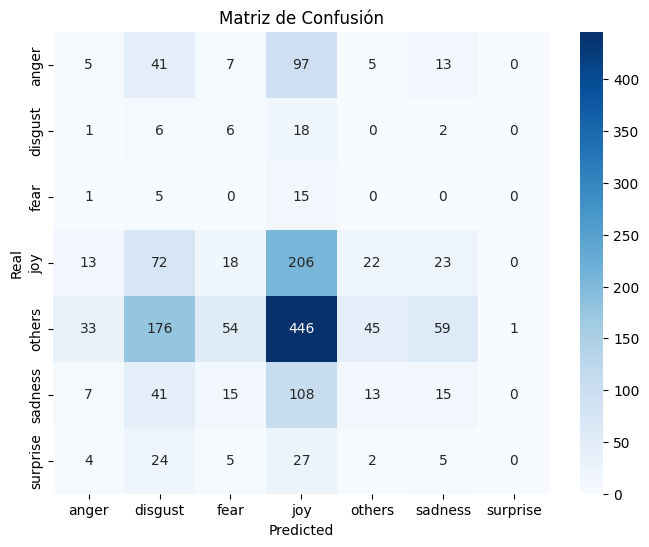

In [68]:
# 3️⃣ Matriz de confusión
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [69]:
# 4️⃣ Análisis por evento
df_test = pd.DataFrame({
    'event': test_df['event'],  # tu dataframe original de test
    'y_true': y_test,
    'y_pred': y_pred_labels
})

In [70]:
# Agrupar por evento y calcular accuracy
event_analysis = df_test.groupby('event').apply(
    lambda x: pd.Series({
        'accuracy': (x['y_true']==x['y_pred']).mean(),
        'n_samples': len(x)
    })
).sort_values(by='accuracy', ascending=False)

print("===== Análisis por evento =====")
print(event_analysis)

===== Análisis por evento =====
                 accuracy  n_samples
event                               
WorldBookDay     0.216667      240.0
ChampionsLeague  0.215517      232.0
LaLiga           0.201681      119.0
SpainElection    0.178899      218.0
GretaThunberg    0.172662      139.0
GameOfThrones    0.150685      219.0
Venezuela        0.115385      234.0
NotreDame        0.097778      225.0


/tmp/ipython-input-3992987716.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_analysis = df_test.groupby('event').apply(


In [71]:
# 5️⃣ Distribución de errores por emoción dentro de cada evento (opcional)
for event in df_test['event'].unique():
    event_df = df_test[df_test['event']==event]
    cm_event = confusion_matrix(event_df['y_true'], event_df['y_pred'], labels=range(len(le.classes_)))
    print(f"\nMatriz de confusión para evento: {event} (n={len(event_df)})")
    print(pd.DataFrame(cm_event, index=le.classes_, columns=le.classes_))


Matriz de confusión para evento: GameOfThrones (n=219)
          anger  disgust  fear  joy  others  sadness  surprise
anger         0        5     4   11       2        0         0
disgust       0        0     3    3       0        0         0
fear          0        0     0    3       0        0         0
joy           0        9    10   22       5        1         0
others        2       17    33   40      11        1         0
sadness       0        7     9   10       1        0         0
surprise      0        3     4    3       0        0         0

Matriz de confusión para evento: SpainElection (n=218)
          anger  disgust  fear  joy  others  sadness  surprise
anger         0        7     1   14       0        0         0
disgust       0        3     0    2       0        0         0
fear          0        1     0    4       0        0         0
joy           2       12     5   23       3        1         0
others        2       27    13   52      13        0         0
sadnes

#______________________________________________________________

#**Evaluación Global y hallazgos clave**
En el entrenamiento de la última versión del modelo LSTM, se observó que la clase joy obtuvo un recall notablemente superior (0.58) y un F1 de 0.32, mientras que clases mayoritarias como others y minoritarias como fear, surprise y anger presentaron recall muy bajo o nulo, resultando en una accuracy global de apenas 0.17. Este patrón evidencia un **problema de desbalance de clases y dificultad del modelo para capturar emociones poco frecuentes**, aun cuando se optimizó el preprocesamiento para conservar elementos clave de los tweets como emojis, hashtags y signos de énfasis.

Las limitaciones actuales reflejan que, aunque ciertos elementos textuales ayudan a predecir emociones positivas, la distribución desigual y la complejidad del lenguaje en redes sociales generan predicciones inconsistentes en otras categorías.

Estos resultados sugieren que futuras implementaciones deberían enfocarse en técnicas de balanceo más sofisticadas, data augmentation textual y ajustes de arquitectura o hiperparámetros, para mejorar la cobertura de todas las emociones y la robustez del modelo.